# Computer Vision Project: Reading Time on Analog Watch Face

* https://huggingface.co/datasets/elischwartz/synthetic-watch-faces-dataset?utm_source=chatgpt.com
* Goal: Using CNN and transferred learning, train a model to read the time from an image of an analog watch face.
* Data: 4 sets of tables meant to be used for training, testing, and validation. Each table has one column containing the image of the watch face and a second column for the time shown on the watch. Together, the dataset totals to 11,000 images.
    * For purposes of this project, mainly limitations of hardware, the only table to be used is the 'train' table made up of 8000 rows. Of the 8000, only a subset will be used.
* Regression problem using CNN and transferred learning to train a model.
    * First regression approach, target variable is a list made up of Hour and Minute.
    * Second regression approach, target variable is the number of minutes from midnight (12:00am/0:00). Highest value should be 779, which 12:59, because analog watches typically do not have 24 hour watch faces. In the dataset such faces are not present, so the 779 maximum works for this project.
    * Categorical approach, 2 target variables: hour and minute.

In [44]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import data as tf_data
from keras import layers
from PIL import Image
import io

In [14]:
#loading dataset
df=pd.read_parquet('watch_faces_train.parquet')
df

,image,text
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,07:28
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,02:28
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,05:02
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,06:16
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,04:14
...,...,...
7995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,02:06
7996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,04:38
7997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,02:49
7998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,06:44


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8000 non-null   object
 1   text    8000 non-null   object
dtypes: object(2)
memory usage: 125.1+ KB


In [16]:
#changing column type (object to datetime)
df['text']=pd.to_datetime(df['text'],format='%H:%M')

#splitting into two columns
df['Hour']=df['text'].dt.hour+df['text'].dt.minute / 60.0 #decimal will hopefully help give more information to model
df['Hour (categorical)']=df['text'].dt.hour #hour column for categorical approach
df['Minute']=df['text'].dt.minute

#final target column
df['Time']=df.apply(lambda x: [x['Hour'],x['Minute']], axis=1)
df

,image,text,Hour,Hour (categorical),Minute,Time
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 07:28:00,7.466667,7,28,"[7.466666666666667, 28]"
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:28:00,2.466667,2,28,"[2.466666666666667, 28]"
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 05:02:00,5.033333,5,2,"[5.033333333333333, 2]"
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 06:16:00,6.266667,6,16,"[6.266666666666667, 16]"
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 04:14:00,4.233333,4,14,"[4.233333333333333, 14]"
...,...,...,...,...,...,...
7995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:06:00,2.100000,2,6,"[2.1, 6]"
7996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 04:38:00,4.633333,4,38,"[4.633333333333333, 38]"
7997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:49:00,2.816667,2,49,"[2.8166666666666664, 49]"
7998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 06:44:00,6.733333,6,44,"[6.733333333333333, 44]"


In [17]:
#minutes from midnight
df['Minutes from Midnight']=(df['Hour (categorical)']*60)+df['Minute']
df

,image,text,Hour,Hour (categorical),Minute,Time,Minutes from Midnight
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 07:28:00,7.466667,7,28,"[7.466666666666667, 28]",448
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:28:00,2.466667,2,28,"[2.466666666666667, 28]",148
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 05:02:00,5.033333,5,2,"[5.033333333333333, 2]",302
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 06:16:00,6.266667,6,16,"[6.266666666666667, 16]",376
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 04:14:00,4.233333,4,14,"[4.233333333333333, 14]",254
...,...,...,...,...,...,...,...
7995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:06:00,2.100000,2,6,"[2.1, 6]",126
7996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 04:38:00,4.633333,4,38,"[4.633333333333333, 38]",278
7997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 02:49:00,2.816667,2,49,"[2.8166666666666664, 49]",169
7998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1900-01-01 06:44:00,6.733333,6,44,"[6.733333333333333, 44]",404


In [18]:
#checking maximum is 779 for 'Minutes from Midnight'
df['Minutes from Midnight'].describe()

count    8000.000000
mean      421.624875
std       207.682836
min        60.000000
25%       242.000000
50%       429.000000
75%       599.000000
max       779.000000
Name: Minutes from Midnight, dtype: float64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   image                  8000 non-null   object        
 1   text                   8000 non-null   datetime64[ns]
 2   Hour                   8000 non-null   float64       
 3   Hour (categorical)     8000 non-null   int32         
 4   Minute                 8000 non-null   int32         
 5   Time                   8000 non-null   object        
 6   Minutes from Midnight  8000 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(2)
memory usage: 343.9+ KB


In [20]:
#Changing dictionary to just keep values
df['image']=df['image'].apply(lambda x: x['bytes'])
df

,image,text,Hour,Hour (categorical),Minute,Time,Minutes from Midnight
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 07:28:00,7.466667,7,28,"[7.466666666666667, 28]",448
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 02:28:00,2.466667,2,28,"[2.466666666666667, 28]",148
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 05:02:00,5.033333,5,2,"[5.033333333333333, 2]",302
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 06:16:00,6.266667,6,16,"[6.266666666666667, 16]",376
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 04:14:00,4.233333,4,14,"[4.233333333333333, 14]",254
...,...,...,...,...,...,...,...
7995,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 02:06:00,2.100000,2,6,"[2.1, 6]",126
7996,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 04:38:00,4.633333,4,38,"[4.633333333333333, 38]",278
7997,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 02:49:00,2.816667,2,49,"[2.8166666666666664, 49]",169
7998,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1900-01-01 06:44:00,6.733333,6,44,"[6.733333333333333, 44]",404


In [21]:
#Convert byte to image
def convert_image(bytes):
    image=Image.open(io.BytesIO(bytes)).convert('RGB')
    return np.array(image)

df['image']=df['image'].apply(convert_image)
df

,image,text,Hour,Hour (categorical),Minute,Time,Minutes from Midnight
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 07:28:00,7.466667,7,28,"[7.466666666666667, 28]",448
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 02:28:00,2.466667,2,28,"[2.466666666666667, 28]",148
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 05:02:00,5.033333,5,2,"[5.033333333333333, 2]",302
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 06:16:00,6.266667,6,16,"[6.266666666666667, 16]",376
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 04:14:00,4.233333,4,14,"[4.233333333333333, 14]",254
...,...,...,...,...,...,...,...
7995,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 02:06:00,2.100000,2,6,"[2.1, 6]",126
7996,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 04:38:00,4.633333,4,38,"[4.633333333333333, 38]",278
7997,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 02:49:00,2.816667,2,49,"[2.8166666666666664, 49]",169
7998,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1900-01-01 06:44:00,6.733333,6,44,"[6.733333333333333, 44]",404


In [81]:
df.describe()

,text,Hour,Hour (categorical),Minute,Minutes from Midnight
count,8000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1900-01-01 07:01:37.492499968,7.027081,6.528625,29.907375,421.624875
min,1900-01-01 01:00:00,1.000000,1.000000,0.000000,60.000000
25%,1900-01-01 04:02:00,4.033333,4.000000,14.000000,242.000000
50%,1900-01-01 07:09:00,7.150000,7.000000,30.000000,429.000000
75%,1900-01-01 09:59:00,9.983333,9.000000,45.000000,599.000000
max,1900-01-01 12:59:00,12.983333,12.000000,59.000000,779.000000
std,NaN,3.461381,3.453103,17.629716,207.682836


(array([156., 163., 157., 158., 162., 156., 139., 167., 166., 125., 157.,
        171., 182., 172., 153., 170., 158., 153., 160., 172., 149., 139.,
        122., 127., 180., 155., 185., 182., 171., 173., 170., 166., 175.,
        162., 170., 131., 174., 158., 143., 146., 155., 156., 160., 179.,
        141., 158., 166., 166., 166., 178.]),
 array([ 60.  ,  74.38,  88.76, 103.14, 117.52, 131.9 , 146.28, 160.66,
        175.04, 189.42, 203.8 , 218.18, 232.56, 246.94, 261.32, 275.7 ,
        290.08, 304.46, 318.84, 333.22, 347.6 , 361.98, 376.36, 390.74,
        405.12, 419.5 , 433.88, 448.26, 462.64, 477.02, 491.4 , 505.78,
        520.16, 534.54, 548.92, 563.3 , 577.68, 592.06, 606.44, 620.82,
        635.2 , 649.58, 663.96, 678.34, 692.72, 707.1 , 721.48, 735.86,
        750.24, 764.62, 779.  ]),
 <BarContainer object of 50 artists>)

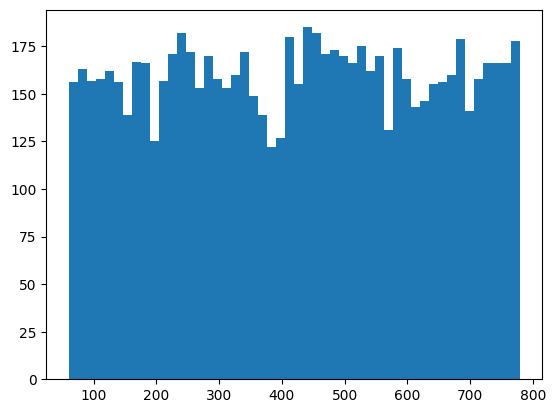

In [88]:
plt.hist(df['Minutes from Midnight'],bins=50)

In [30]:
#convert to tensor
df['image']=df['image'].apply(lambda x: tf.convert_to_tensor(x, dtype=tf.float32)/255) #conversion + normalize
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   image                  8000 non-null   object        
 1   text                   8000 non-null   datetime64[ns]
 2   Hour                   8000 non-null   float64       
 3   Hour (categorical)     8000 non-null   int32         
 4   Minute                 8000 non-null   int32         
 5   Time                   8000 non-null   object        
 6   Minutes from Midnight  8000 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(2)
memory usage: 343.9+ KB


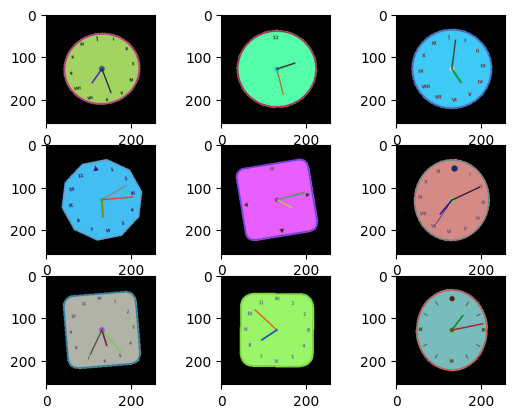

In [31]:
#checking that image properly loads
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(df['image'][i])

In [41]:
data_augmentation_layers = [
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.15,0.15)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0216408].


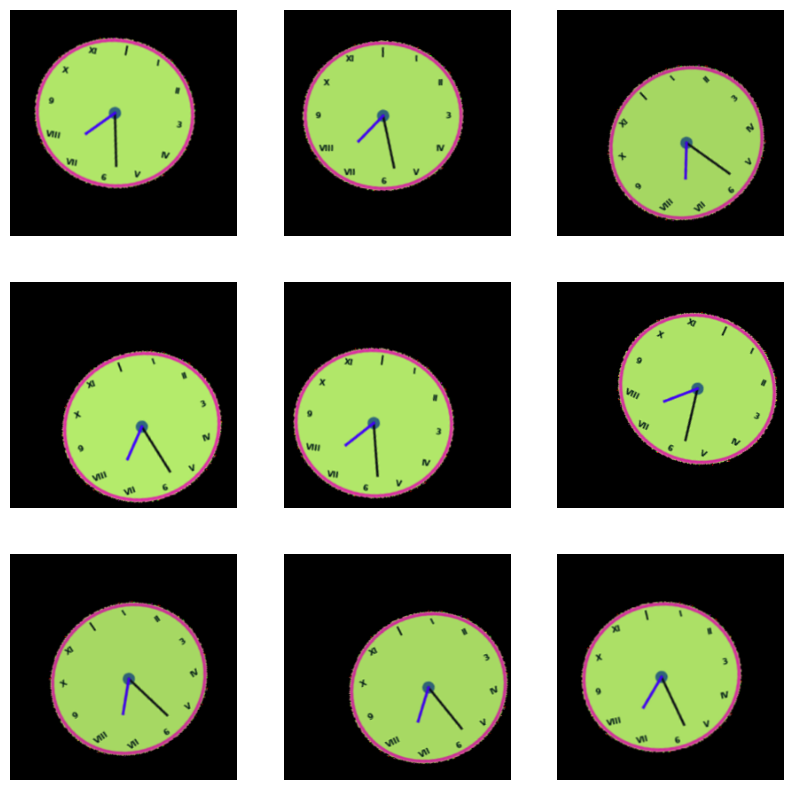

In [42]:
plt.figure(figsize=(10, 10))
for images in df['image'].take([0]):
    images=tf.expand_dims(images, axis=0)
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        #plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.imshow(tf.squeeze(augmented_images).numpy())
        plt.axis("off")

In [77]:
#changing my pandas DataFrame to tf dataset; using 'Minutes from Midnight'
df100=df[:100]
images=list(df100['image'])
labels=df100['Minutes from Midnight'].astype('float32').values
tf_dataset=tf.data.Dataset.from_tensor_slices((images,labels))

In [78]:
train_ds=tf_dataset.take(80)
val_ds=tf_dataset.skip(80)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds=train_ds.batch(10)
val_ds=val_ds.batch(10)

### Testing to make sure everything will work to train a model
* Using CNN with no transfer learning just to test
* Will use transfer learning on actual model (prototype and production notebooks)

In [46]:
import keras
from tensorflow.keras import layers, models

In [58]:
def make_model(input_shape=(256, 256, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model

In [79]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model=make_model()

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 173790.2188 - mae: 377.0539 - val_loss: 190707.2812 - val_mae: 397.6678
Epoch 2/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 124455.8594 - mae: 308.6389 - val_loss: 68702.6250 - val_mae: 212.0993
Epoch 3/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 62374.4180 - mae: 218.1451 - val_loss: 64960.5117 - val_mae: 212.7834
Epoch 4/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 45616.2539 - mae: 172.5256 - val_loss: 38578.1367 - val_mae: 147.2026
Epoch 5/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 44167.2578 - mae: 175.2804 - val_loss: 43705.0508 - val_mae: 178.9920
Epoch 6/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 37767.2188 - mae: 156.8611 - val_loss: 34573.7578 - val_mae: 150.9679
Epoch 7/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 38667.3555 - mae: 165.4620 - val_loss: 38206.6641 - val_mae: 168.9641
Epoch 8/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 38067.6484 - mae: 163.9796 - val_loss: 34966.7656 -

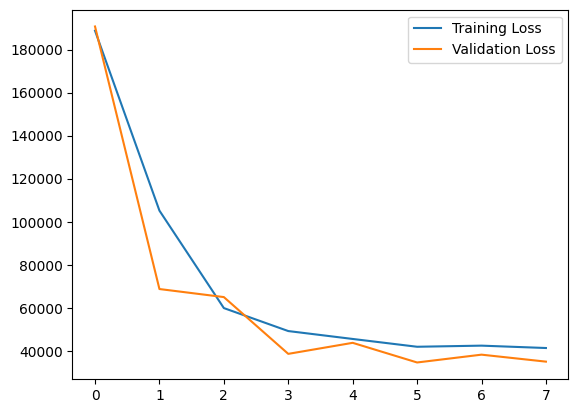

In [80]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()